In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import datetime
from datetime import datetime
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
%matplotlib inline
sns.set_style('white')

In [2]:
df = pd.read_csv('advertising.csv')

In [3]:
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


In [4]:
#Checking to see if there are any null values in the dataset to clean up
df.isnull().values.any()

False

Text(0.5, 1.0, 'Daily Internet Usage')

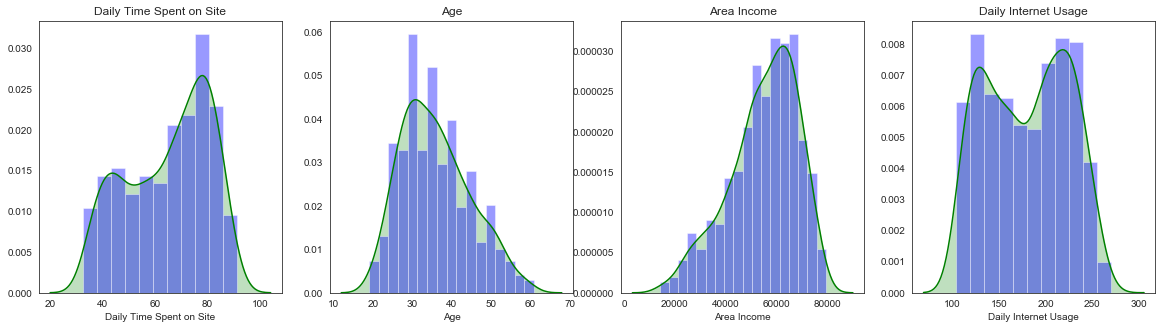

In [5]:
#Determining normality for our continuous variables
fig = plt.figure(figsize=(20,5))

fig.add_subplot(141)
sns.distplot(df['Daily Time Spent on Site'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Daily Time Spent on Site')

fig.add_subplot(142)
sns.distplot(df['Age'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Age')

fig.add_subplot(143)
sns.distplot(df['Area Income'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Area Income')

fig.add_subplot(144)
sns.distplot(df['Daily Internet Usage'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Daily Internet Usage')

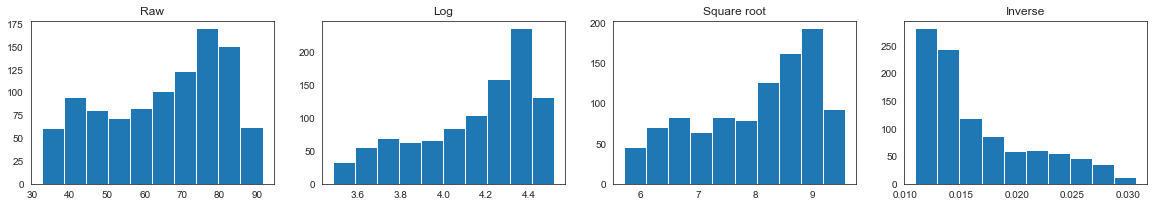

In [7]:
# Age and Area Income appear to be reasonably normal
# Time on Site and Internet Usage are not, so let's look at some transformations

fig = plt.figure(figsize=(20,3))

fig.add_subplot(141)
plt.hist(df['Daily Time Spent on Site'].dropna())
plt.title('Raw')

fig.add_subplot(142)
plt.hist(np.log(df['Daily Time Spent on Site'].dropna()))
plt.title('Log')

fig.add_subplot(143)
plt.hist(np.sqrt(df['Daily Time Spent on Site'].dropna()))
plt.title('Square root')

ax3=fig.add_subplot(144)
plt.hist(1/df['Daily Time Spent on Site'].dropna())
plt.title('Inverse')
plt.show()

# The square root transformation, while skewed left, is closest to normal.

df['Daily Time Spent on Site_sqrt'] = np.sqrt(df['Daily Time Spent on Site'])

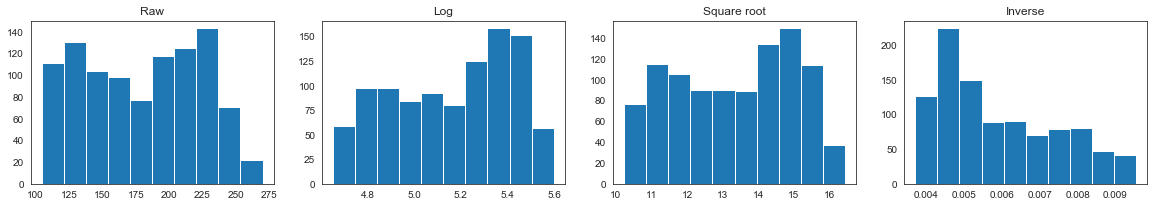

In [9]:
# Normalizing 'Daily Internet Usage'

fig = plt.figure(figsize=(20,3))

fig.add_subplot(141)
plt.hist(df['Daily Internet Usage'].dropna())
plt.title('Raw')

fig.add_subplot(142)
plt.hist(np.log(df['Daily Internet Usage'].dropna()))
plt.title('Log')

fig.add_subplot(143)
plt.hist(np.sqrt(df['Daily Internet Usage'].dropna()))
plt.title('Square root')

ax3=fig.add_subplot(144)
plt.hist(1/df['Daily Internet Usage'].dropna())
plt.title('Inverse')
plt.show()

# The log transformation, while skewed right, is closest to normal.

df['Daily Internet Usage_log'] = np.log(df['Daily Internet Usage'])

In [10]:
# Create a features dataframe

features = df.iloc[:,1:3]
features['Daily Time Spent on Site_sqrt'] = df['Daily Time Spent on Site']
features['Daily Internet Usage_log'] = df['Daily Internet Usage_log']
features['Male'] = df['Male']
features.head()

,Age,Area Income,Daily Time Spent on Site_sqrt,Daily Internet Usage_log,Male
0,35,61833.90,68.95,5.545529,0
1,31,68441.85,80.23,5.266672,1
2,26,59785.94,69.47,5.465948,0
3,29,54806.18,74.15,5.504884,1
4,35,73889.99,68.37,5.418675,0


In [11]:
# Features from Timestamp
# Let's split up this timestamp and see if we can make it more usable

hour = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).hour
features['Hour'] = df['Timestamp'].map(hour)

day = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).day
features['Day'] = df['Timestamp'].map(day)

month = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).month
features['Month'] = df['Timestamp'].map(month)

features.head()

,Age,Area Income,Daily Time Spent on Site_sqrt,Daily Internet Usage_log,Male,Hour,Day,Month
0,35,61833.90,68.95,5.545529,0,0,27,3
1,31,68441.85,80.23,5.266672,1,1,4,4
2,26,59785.94,69.47,5.465948,0,20,13,3
3,29,54806.18,74.15,5.504884,1,2,10,1
4,35,73889.99,68.37,5.418675,0,3,3,6


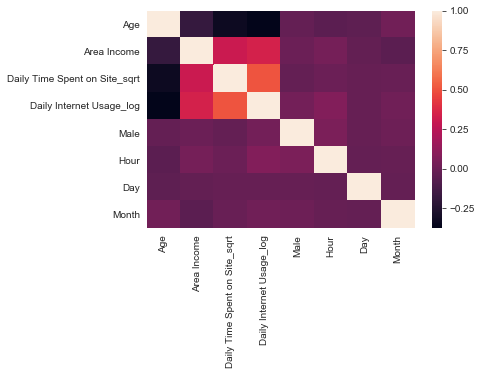

In [12]:
# Testing for multicollinearity

sns.heatmap(features.corr())

## Logistic Regression

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in long_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


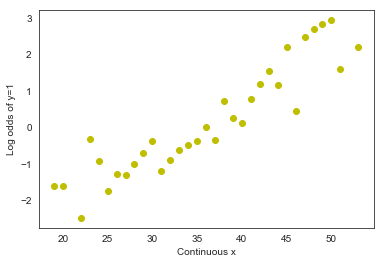

In [14]:
# Convert binary values into odds of getting y=1

# continuous predictor
x = features['Age']

# binary outcome
bin_y = df['Clicked on Ad']

# Unique values in x
xvals = x.unique()

# Calculate and store the odds
yodds = []
for xi in xvals:
    y1_ct = bin_y[x == xi].sum() # the number of trials where y = 1
    y0_ct = len(bin_y[x == xi]) - y1_ct # the number of trials where y = 0
    yodds.append(y1_ct / y0_ct) # odds of getting y = 1 for xi
    
# Natural log of the odds
ln_yodds = np.log(yodds)

# calculate linear regression for x and odds
fit = np.polyfit(xvals, ln_yodds, 1)

# works as a function to return the predicted value of yodds
fit_fn = np.poly1d(fit)

# display
plt.plot(xvals, ln_yodds, 'yo', xvals, fit_fn(xvals), '--k')
plt.xlabel('Continuous x')
plt.ylabel('Log odds of y=1')
plt.show()

In [16]:
ln_yodds

array([-0.36290549, -1.18958407, -1.28785429, -0.69314718, -0.31845373,
       -0.62415431,  2.7080502 , -0.36290549, -1.60943791,  2.83321334,
       -0.33647224, -0.91629073,  0.78845736,  0.        ,  0.11122564,
               inf, -0.9903987 , -0.47000363, -2.48490665,         inf,
        2.19722458,  0.26826399,  0.45198512, -0.89794159, -1.74919985,
        1.55814462,  2.19722458,  2.94443898,  2.48490665, -1.31218639,
        1.2039728 ,  0.73396918,         inf,        -inf,         inf,
               inf,  1.16315081,         inf,         inf,  1.60943791,
       -1.60943791,         inf,         inf])

In [22]:
# Declare predictors
X_statsmod = features[['Age', 'Area Income', 'Daily Time Spent on Site_sqrt',
                      'Daily Internet Usage_log', 'Male', 'Hour', 'Day', 'Month']]

# The statsmodels formulation requires a column with a constant value 1 that
# will act as the intercept
X_statsmod['intercept'] = 1

# declare and fit the model
logit = sm.Logit(df['Clicked on Ad'], X_statsmod)
result = logit.fit()

# Lots of information about the model and its coefficients, but no
# accuracy rate for predictions is missing
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.087770
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:          Clicked on Ad   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      991
Method:                           MLE   Df Model:                            8
Date:                Sat, 26 Jan 2019   Pseudo R-squ.:                  0.8734
Time:                        11:46:10   Log-Likelihood:                -87.770
converged:                       True   LL-Null:                       -693.15
                                        LLR p-value:                4.551e-256
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Age                               0.1625      0.026      6.314      0

In [25]:
# calculate accuracy. first get probability that each row will be admitted
pred_statsmod = result.predict(X_statsmod)

# code admission of 1 as if probability is greater than .5
pred_y_statsmod = np.where(pred_statsmod < .5, 0, 1)

# accuracy table
table = pd.crosstab(df['Clicked on Ad'], pred_y_statsmod)

print('\n Accuracy by click success')
print(table)
print('\n Percentage accuracy')
print((table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum()))


 Accuracy by click success
col_0            0    1
Clicked on Ad          
0              489   11
1               20  480

 Percentage accuracy
0.969


In [27]:
# logistic regression classifier (SKlearn)
# parameter regularization coefficient c

lr = LogisticRegression(C=1e50)
X = features[['Age', 'Area Income', 'Daily Time Spent on Site_sqrt', 
              'Daily Internet Usage_log', 'Male', 'Hour', 'Day', 'Month']]
y = df['Clicked on Ad']

# fit the model
fit = lr.fit(X, y)

# Display
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
pred_y_sklearn = lr.predict(X)

print('\n Accuracy by admission status')
print(pd.crosstab(pred_y_sklearn, y))

print('\n Percentage accuracy')
print(lr.score(X, y))

Coefficients
[[ 2.27050414e-01 -4.59769011e-05 -1.08438313e-01  9.23330576e-02
  -6.04111924e-03  3.22109210e-02  3.20347196e-02  9.53470356e-02]]
[0.03333263]

 Accuracy by admission status
Clicked on Ad    0    1
row_0                  
0              467   73
1               33  427

 Percentage accuracy
0.894


## Ridge Regression

In [28]:
X_train = features[['Age', 'Area Income', 'Daily Time Spent on Site_sqrt', 
                    'Daily Internet Usage_log', 'Male', 'Hour', 'Day', 'Month']]
Y_train = df['Clicked on Ad']

# fitting a ridge regression model. alpha is the regularization
# parameter (usually called lambda). as alpha gets larger, parameter
# shrinkage grows more pronounced

# by convention, the intercept is not regularized.
# we did not standardize the data so the intercept is not equal to zero
# and cannot be dropped

ridgeregr = linear_model.Ridge(alpha=5)
ridgeregr.fit(X_train, Y_train)
print(ridgeregr.score(X_train, Y_train))
origparams = ridgeregr.coef_[0]
print(origparams)

0.8232104651753415
0.009161978920063912


## Lasso Regression

In [29]:
lass = linear_model.Lasso(alpha=.4)
lassfit = lass.fit(X_train, Y_train)
print('R Squared:')
print(lass.score(X_train, Y_train))
origparamsL = np.append(lassfit.coef_, lassfit.intercept_)
print('\nParameter estimates:')
print(origparamsL)

R Squared:
0.6724176543010172

Parameter estimates:
[ 9.49949749e-03 -1.01555504e-05 -1.75959572e-02 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  1.86022861e+00]


## Conclusion

I believe that in this particular instance, it' a toss up between vanilla logistic regression and ridge regression. The R^2 in both instances is in the 0.8 range, which gives me enough confidence that the model was not overfitting. Perhaps Lasso regression would be more appropriate if the data was a bit more complicated or part of a much larger set.